In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import scipy.stats as stats
from scipy.stats import kstest
import sklearn.model_selection as skms
import sklearn.metrics as skm
import sklearn.preprocessing as skp
import sklearn.ensemble as ske
import sklearn.linear_model as sklm
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import   KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from imblearn.over_sampling import SMOTE



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
flights = pd.read_csv('/content/drive/My Drive/Colab Notebooks/flights_sample5pct.csv')


# fuel = pd.read_csv('/content/drive/My Drive/Colab Notebooks/fuel_comsumption.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
flights_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/flights_test.csv')

In [22]:
# if 'flights' in locals():
#   date_split = flights['fl_date'].str.split('-')
#   flights['year'] = [x[0] for x in date_split]
#   flights['month'] = [x[1] for x in date_split]
#   flights['month'] = flights['month']
#   flights['day'] = [x[2] for x in date_split]

if 'flights_test' in locals():
  date_split = flights_test['fl_date'].str.split('-')
  flights_test['year'] = [x[0] for x in date_split]
  flights_test['month'] = [x[1] for x in date_split]
  flights_test['month'] = flights['month'].astype(dtype="category")
  flights_test['day'] = [x[2] for x in date_split]

del date_split

In [7]:
# fullflights = pd.read_csv('/content/drive/My Drive/Colab Notebooks/flights.csv')

In [8]:
# # Separate out non-null data from columns with >80% nulls to train with
# fullflights[
#             (fullflights.carrier_delay.notnull() &
#             fullflights.weather_delay.notnull() &
#             fullflights.nas_delay.notnull() &
#             fullflights.security_delay.notnull() &
#             fullflights.late_aircraft_delay.notnull())
# ].to_csv('/content/drive/My Drive/Colab Notebooks/flights_notnulldelay.csv')

In [9]:
# Cleaning Functions

  
def eliminateCorrFeatures(coef_, df):
    """
    coef_ should be between 0 and 1
    """
    # step 1
    df_corr = df.corr().abs()

    # step 2
    indices = np.where(df_corr > coef_) 
    indices = [(df_corr.index[x], df_corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]

    # step 3
    for idx in indices: #each pair
        try:
            df.drop(idx[1], axis = 1, inplace=True)
        except KeyError:
            pass
    return df

from sklearn.feature_selection import VarianceThreshold
def eliminateLowVariance(x, df):
    """
    x should be between 0 and 1
    """
    vt = VarianceThreshold(x)
    vt.fit(df)
    return df.loc[:, vt.variances_ > x]


def calc_specificity(y_actual, y_pred, thresh):
  return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)
def print_report(y_actual, y_pred, thresh):


  auc = skm.roc_auc_score(y_actual, y_pred)
  accuracy = skm.accuracy_score(y_actual, (y_pred > thresh))
  recall = skm.recall_score(y_actual, (y_pred > thresh))
  precision = skm.precision_score(y_actual, (y_pred > thresh))
  specificity = calc_specificity(y_actual, y_pred, thresh)
  print(f'AUC:{auc:%.3f}')
  print(f'accuracy:{accuracy:%.3f}')
  print(f'recall:{recall:%.3f}')
  print(f'precision:{precision:%.3f}')
  print(f'specificity:{specificity:%.3f}')
  print(' ')
  return auc, accuracy, recall, precision, specificity

# Machine Learning

In this file, we can find all instructions how to approach Machine Learning challenge and how to submit results in the correct form. 

We are going to work on three different types of Machine Learning problem:

- **Regression Problem**: The goal is to predict delay of flights.
- **Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **Binary Classification**: The goal is to predict if the flight will be cancelled.

# FEATURE ENGINEERING

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering? kmeans
- **what are the additional options?**: Think about what we could do more to improve the model.

# Categories that do have effect on predictor
## Get Historical Delay Info for:
- by month 
  + mean(dep_delay)
  + mean(taxi_out)
  + mean(taxi_in)
  + mean(arr_delay)


# Cities based on how busy they are (by passengers)
- origin_city_name 
- dest_city_name



# Categories that have no effect on predictor
- crs_dep_time is derivative, dep_time - dep_delay
- wheels_off - dep_time is taxi time
- air time has no correlation with arr_delay, so we exclude it and similar measures of travel time
- Ignore: mkt_unique_carrier 	branded_code_share 	mkt_carrier
['Unnamed: 0','mkt_carrier_fl_num', 'op_carrier_fl_num', 'origin_airport_id', 	'origin','dest_airport_id',	'dest', 'crs_dep_time','wheels_off','wheels_on','crs_arr_time','crs_elapsed_time', 	'actual_elapsed_time', 	'air_time']


## Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

In [10]:
def busiest_airport_bypassengers(flights_hist, flight_test):
  passengers = pd.read_csv('/content/drive/My Drive/Colab Notebooks/passengers.csv')
  df1 = passengers[['passengers','origin_city_name']]
  df2 = passengers[['passengers','dest_city_name']]
  df1 = df1.rename(columns={'origin_city_name':'origin_city_name'})
  df2 = df2.rename(columns={'dest_city_name':'origin_city_name'})
  df3 = pd.concat((df1,df2), axis=0)
  df4 = df3.groupby('origin_city_name').sum().sort_values('passengers', ascending=False).reset_index()
  df4['pct_traffic'] = round(df4.passengers / passengers.passengers.sum(),2)*100
  city_ranker = df4
  city_ranker_dict = pd.Series(city_ranker.pct_traffic.values,index=city_ranker.origin_city_name).to_dict()

  return pd.DataFrame({
              'busy_origin_factor': flight_test['origin_city_name'].map(city_ranker_dict).astype(int),
              'busy_dest_factor': flight_test['dest_city_name'].map(city_ranker_dict).astype(int) })

def dayofweek_means(flights_hist, flight_test):
  flights['fl_date'] = pd.to_datetime(flights['fl_date'])
  flights['day_of_week'] = flights['fl_date'].dt.dayofweek
  flight_test['fl_date'] = pd.to_datetime(flight_test['fl_date'])
  flight_test['day_of_week'] = flight_test['fl_date'].dt.dayofweek

  DOW_dep_meandct = flights.groupby('day_of_week').dep_delay.median().to_dict() 
  DOW_arr_meandct = flights.groupby('day_of_week').arr_delay.median().to_dict()
  DOW_taxiout_meandct = flights.groupby('day_of_week').taxi_out.median().to_dict() 
  DOW_taxiin_meandct = flights.groupby('day_of_week').taxi_in.median().to_dict()
  return pd.DataFrame({
      'DOW_dep_mean': flight_test['day_of_week'].map(DOW_dep_meandct),
      'DOW_arr_mean':flight_test['day_of_week'].map(DOW_arr_meandct),
      'DOW_taxiout_mean':flight_test['day_of_week'].map(DOW_taxiout_meandct),
      'DOW_taxiin_mean':flight_test['day_of_week'].map(DOW_taxiin_meandct),
      'day_of_week':flight_test['fl_date'].dt.dayofweek.astype(int)  })
  
def month_means(flights_hist, flight_test):
  month_dep_meandct = flights.groupby('month').dep_delay.median().to_dict() 
  month_arr_meandct = flights.groupby('month').arr_delay.median().to_dict() 
  month_taxiout_meandct = flights.groupby('month').taxi_out.median().to_dict() 
  month_taxiin_meandct = flights.groupby('month').taxi_in.median().to_dict() 
  return pd.DataFrame({
              'month_dep_mean':flight_test['month'].map(month_dep_meandct),
              'month_arr_mean':flight_test['month'].map(month_arr_meandct),
              'month_taxiout_mean':flight_test['month'].map(month_taxiout_meandct),
              'month_taxiin_mean':flight_test['month'].map(month_taxiin_meandct) })

def arrhour_means(flights_hist, flight_test):
  bins = [0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400] # bins for hour of the day. Each bin is 3hr duration
  flights['binned_arr'] = np.searchsorted(bins, flights['crs_arr_time'].values)
  flight_test['binned_arr'] = np.searchsorted(bins, flight_test['crs_arr_time'].values)

  arrhour_dep_meandct = flights.groupby('binned_arr').dep_delay.median().to_dict() 
  arrhour_arr_meandct = flights.groupby('binned_arr').arr_delay.median().to_dict() 
  arrhour_taxiout_meandct = flights.groupby('binned_arr').taxi_out.median().to_dict() 
  arrhour_taxiin_meandct = flights.groupby('binned_arr').taxi_in.median().to_dict()  
  return pd.DataFrame({
              'arrhour_dep_mean':flight_test['binned_arr'].map(arrhour_dep_meandct),
              'arrhour_arr_mean':flight_test['binned_arr'].map(arrhour_arr_meandct),
              'arrhour_taxiout_mean': flight_test['binned_arr'].map(arrhour_taxiout_meandct),
              'arrhour_taxiin_mean':flight_test['binned_arr'].map(arrhour_taxiin_meandct),
               'crs_arr_bin':np.searchsorted(bins, flight_test['crs_arr_time'].values).astype(int)})

def dephour_means(flights_hist, flight_test):
  bins = [0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400] # bins for hour of the day. Each bin is 3hr duration
  flights['binned_dep'] = np.searchsorted(bins, flights['crs_dep_time'].values)
  flight_test['binned_dep'] = np.searchsorted(bins, flight_test['crs_dep_time'].values)

  dephour_dep_meandct = flights.groupby('binned_dep').dep_delay.median().to_dict() 
  dephour_arr_meandct = flights.groupby('binned_dep').arr_delay.median().to_dict() 
  dephour_taxiout_meandct = flights.groupby('binned_arr').taxi_out.median().to_dict()
  dephour_taxiin_meandct = flights.groupby('binned_arr').taxi_in.median().to_dict()  
  return pd.DataFrame({'dephour_dep_mean':flight_test['binned_dep'].map(dephour_dep_meandct),
                    'dephour_arr_mean':flight_test['binned_dep'].map(dephour_arr_meandct),
                    'dephour_taxiout_mean':flight_test['binned_dep'].map(dephour_taxiout_meandct),
                    'dephour_taxiin_mean':flight_test['binned_dep'].map(dephour_taxiin_meandct),
                    'crs_dep_bin':np.searchsorted(bins, flight_test['crs_dep_time'].values).astype(int)})


def distance_means(flights_hist, flight_test):
  bins = [0, 1100, 4100, 10000] #bins for short, medium and long distance flights
  flights['binned_distance'] = np.searchsorted(bins, flights['distance'].values)
  flight_test['binned_distance'] = np.searchsorted(bins, flight_test['distance'].values)

  dist_dep_meandct = flights.groupby('binned_distance').dep_delay.median().to_dict()
  dist_arr_meandct = flights.groupby('binned_distance').arr_delay.median().to_dict() 
  dist_taxiout_meandct = flights.groupby('binned_distance').taxi_out.median().to_dict() 
  dist_taxiin_meandct = flights.groupby('binned_distance').taxi_in.median().to_dict() 
  return pd.DataFrame({'dist_dep_mean':flight_test['binned_distance'].map(dist_dep_meandct),
                    'dist_arr_mean':flight_test['binned_distance'].map(dist_arr_meandct),
                    'dist_taxiout_mean':flight_test['binned_distance'].map(dist_taxiout_meandct),
                    'dist_taxiin_mean':flight_test['binned_distance'].map(dist_taxiin_meandct),
                    'binned_distance':np.searchsorted(bins, flight_test['distance'].values).astype(int)})

def carrier_means(flights_hist, flight_test):
  carrier_dep_meandct = flights.groupby('mkt_carrier').dep_delay.median().to_dict()
  carrier_arr_meandct = flights.groupby('mkt_carrier').arr_delay.median().to_dict()
  carrier_taxiout_meandct = flights.groupby('mkt_carrier').taxi_out.median().to_dict()
  carrier_taxiin_meandct = flights.groupby('mkt_carrier').taxi_in.median().to_dict() 

  return pd.DataFrame({'carrier_dep_mean':flight_test['mkt_carrier'].map(carrier_dep_meandct),
                    'carrier_arr_mean':flight_test['mkt_carrier'].map(carrier_arr_meandct),
                    'carrier_taxiout_mean':flight_test['mkt_carrier'].map(carrier_taxiout_meandct),
                    'carrier_taxiin_mean':flight_test['mkt_carrier'].map(carrier_taxiin_meandct)})

def city_means(flights_hist, flight_test):
  origin_dep_meandct = flights.groupby('origin').dep_delay.median().to_dict() 
  origin_arr_meandct = flights.groupby('origin').arr_delay.median().to_dict() 
  origin_taxiout_meandct = flights.groupby('origin').taxi_out.median().to_dict()
  origin_taxiin_meandct = flights.groupby('origin').taxi_in.median().to_dict()

  dest_dep_meandct = flights.groupby('dest').dep_delay.median().to_dict() 
  dest_arr_meandct = flights.groupby('dest').arr_delay.median().to_dict()
  dest_taxiout_meandct = flights.groupby('dest').taxi_out.median().to_dict() 
  dest_taxiin_meandct = flights.groupby('dest').taxi_in.median().to_dict() 
  return pd.DataFrame( {'dest_dep_mean':flight_test['dest'].map(dest_dep_meandct),
            'dest_arr_mean':flight_test['dest'].map(dest_arr_meandct),
            'dest_taxiout_mean':flight_test['dest'].map(dest_taxiout_meandct),
            'dest_taxiin_mean':flight_test['dest'].map(dest_taxiin_meandct),
            'origin_dep_mean':flight_test['origin'].map(origin_dep_meandct),
            'origin_arr_mean':flight_test['origin'].map(origin_arr_meandct),
            'origin_taxiout_mean':flight_test['origin'].map(origin_taxiout_meandct),
            'origin_taxiin_mean':flight_test['origin'].map(origin_taxiin_meandct)})

def createX(flights, model_frame, original_cols_tokeep ):
  return pd.concat( [flights[original_cols_tokeep].copy(), 
                      busiest_airport_bypassengers(flights, model_frame),
                      dayofweek_means(flights, model_frame),
                    month_means(flights, model_frame),
                    arrhour_means(flights, model_frame),
                    dephour_means(flights, model_frame),
                    distance_means(flights, model_frame),
                    carrier_means(flights, model_frame),                   
                    city_means(flights, model_frame) ], axis=1)

In [11]:
# THIS CELL CREATES THE X DATA FRAME THAT CAN BE USED FOR TRAINING, TESTING, SPLITTING
# as well as Y target variables for all three learning problems

# CHOOSE THE DATA FRAME TO MODEL WITH
model_frame = 'flights'
model = 'regress' # multiclass / regress / binary

original_cols_tokeep = ['mkt_carrier_fl_num','mkt_carrier', 'origin','dest','month','cancelled'] # 'op_carrier_fl_num',

X = createX(flights, flights, original_cols_tokeep )
X.month = pd.to_numeric(X.month)
# Further Cleaning
# Group Non-delays as 0
# for col in X.filter(regex='_mean', axis=1).columns:
#   X[col] = X[col].apply(lambda x: 0 if x < 0 else x )
# X.head()

# Drop low variance columns for mean data only
# varthresh = 0.1
# T = X.filter(regex='_mean', axis=1)
# vt = VarianceThreshold(varthresh)
# vt.fit(T)
# lowvarcols = T.loc[:, vt.variances_ < varthresh].columns.to_list()
# X.drop(lowvarcols, axis=1, inplace=True)
# del T


if model_frame == 'flights':
  if model == 'regress':
    Y = flights.arr_delay.copy()
    Y.fillna(Y.median(), inplace=True)
    X.drop(['cancelled'], axis=1, inplace=True)
    le = skp.LabelEncoder()
    for col in X[['mkt_carrier_fl_num','mkt_carrier','origin','dest' ]].columns:
      X[col] = le.fit_transform(X[col])

  elif model == 'multiclass':
    multi_target_cols = ['carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay']
    # Creating dummy variable dataframe identifying the largest delay type
    flights['largest_target_delay'] = flights[multi_target_cols].idxmax(axis="columns")
    Y = pd.get_dummies(flights['largest_target_delay'])
    Y = Y[Y > 0].dropna(how='all').fillna(0)
    X = X.iloc[Y.index.to_list(),]
    # Classifiers algos typ. only do binary, to use multiple labels encode or use OneVRest type strats, I choose encode
    target_encoding = {'carrier_delay': 0, 	'late_aircraft_delay': 1, 	'nas_delay': 2, 	'security_delay': 3, 	'weather_delay': 4}
    Y = Y.idxmax(axis="columns").map(target_encoding)
    # X_dummies = pd.get_dummies( X_multiclass[['op_unique_carrier', 'origin_city_name', 'dest_city_name']])
    X.drop(['mkt_carrier_fl_num','mkt_carrier', 'origin','dest','cancelled'], axis=1, inplace=True)
    # X_multiclass = pd.concat([X_multiclass,X_dummies] , axis=1).fillna(0)
    # minority_sample = df_dum[df_dum[multi_target_cols] == 1]
    # majority_sample = df_dum[df_dum[multi_target_cols] == 0].sample(n=len(minority_sample))
    # Y_multiclass = pd.concat([minority_sample, majority_sample])


  else:
    # Binary Target
    Y = flights.cancelled.copy()
    X.drop(['mkt_carrier_fl_num','mkt_carrier', 'origin','dest'], axis=1, inplace=True)

In [26]:
X.head()

,mkt_carrier_fl_num,mkt_carrier,origin,dest,month,busy_origin_factor,busy_dest_factor,DOW_dep_mean,DOW_arr_mean,DOW_taxiout_mean,DOW_taxiin_mean,day_of_week,month_dep_mean,month_arr_mean,month_taxiout_mean,month_taxiin_mean,arrhour_dep_mean,arrhour_arr_mean,arrhour_taxiout_mean,arrhour_taxiin_mean,crs_arr_bin,dephour_dep_mean,dephour_arr_mean,dephour_taxiout_mean,dephour_taxiin_mean,crs_dep_bin,dist_dep_mean,dist_arr_mean,dist_taxiout_mean,dist_taxiin_mean,binned_distance,carrier_dep_mean,carrier_arr_mean,carrier_taxiout_mean,carrier_taxiin_mean,dest_dep_mean,dest_arr_mean,dest_taxiout_mean,dest_taxiin_mean,origin_dep_mean,origin_arr_mean,origin_taxiout_mean,origin_taxiin_mean
0,517,3,103,230,5,3,1,-3.0,-7.0,15.0,6.0,1,-2.0,-6.0,15.0,6.0,-3.0,-7.0,15.0,6.0,5,-2.0,-6.0,15.0,6.0,5,-3.0,-6.0,15.0,6.0,1,-3.0,-9.0,16.0,6.0,-2.0,-6.0,16.0,5.0,-2.0,-8.0,16.0,6.0
1,668,3,257,243,5,10,4,-3.0,-7.0,15.0,6.0,1,-2.0,-6.0,15.0,6.0,-1.0,-4.0,15.0,6.0,7,-1.0,-4.0,15.0,6.0,6,-3.0,-6.0,15.0,6.0,1,-3.0,-9.0,16.0,6.0,-3.0,-9.0,15.0,5.0,-2.0,-4.0,20.0,5.0
2,696,3,257,321,5,10,5,-3.0,-7.0,15.0,6.0,1,-2.0,-6.0,15.0,6.0,-2.0,-5.0,15.0,6.0,6,-2.0,-6.0,15.0,6.0,5,-1.0,-6.0,15.0,7.0,2,-3.0,-9.0,16.0,6.0,-3.0,-4.0,15.0,9.0,-2.0,-4.0,20.0,5.0
3,718,3,46,243,5,0,4,-3.0,-7.0,15.0,6.0,1,-2.0,-6.0,15.0,6.0,-3.0,-8.0,15.0,6.0,4,-4.0,-9.0,14.0,6.0,2,-1.0,-6.0,15.0,7.0,2,-3.0,-9.0,16.0,6.0,-3.0,-9.0,15.0,5.0,-4.0,-7.0,12.0,6.0
4,724,3,353,196,5,2,8,-3.0,-7.0,15.0,6.0,1,-2.0,-6.0,15.0,6.0,-1.0,-4.0,15.0,6.0,8,-1.0,-3.0,15.0,6.0,7,-1.0,-6.0,15.0,7.0,2,-3.0,-9.0,16.0,6.0,-2.0,-6.0,16.0,10.0,-2.0,-6.0,12.0,6.0


In [27]:
# FOR FLIGHTS_TEST
original_cols_tokeep = ['mkt_carrier_fl_num','mkt_carrier', 'origin','dest','month'] # 'op_carrier_fl_num',

Xfltest = createX(flights, flights_test, original_cols_tokeep )
Xfltest.month = pd.to_numeric(X.month)
le = skp.LabelEncoder()
for col in Xfltest[['mkt_carrier_fl_num','mkt_carrier','origin','dest' ]].columns:
  Xfltest[col] = le.fit_transform(Xfltest[col])

In [35]:
Xfltest = scaler_std.fit_transform(Xfltest.values)
final_predict = xgb1.predict(Xfltest)



In [67]:
final_submission = flights_test[[ 'fl_date','mkt_carrier','mkt_carrier_fl_num', 'origin','dest']]
final_submission['predicted_delay'] = final_predict[:len(flights_test)]
final_submission.head()
final_submission.to_csv('JonPhani_finalsubmission.csv')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

## Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

Final evaluation will be done on data from January 2020 to compare the results from all teams on **out of sample** data. We are required to predict delays on flights from first 7 days of 2020 (1st of January - 7th of January). We can find sample submission in file _sample_submission.csv_

### Regression

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [14]:
%%time
#==================================================================
#              REGRESSION
#==================================================================

scaler_std = skp.StandardScaler()
Xst = scaler_std.fit_transform(X.values)
Yst = scaler_std.fit_transform(Y.values.reshape(-1, 1))


test_size = 0.3
X_train, X_test, y_train, y_test = skms.train_test_split(
   Xst, Yst,
    test_size = test_size, random_state= 10) 

xgb1 = xgb.XGBRegressor(n_estimators=1000, max_depth=5,learning_rate=0.01, seed = 42, reg_alpha=0.01, colsample_bytree=0.4)

xgb1.fit(X_train,y_train)
print("Accuracy on training set for XGBoost: {:.3f}".format(xgb1.score(X_train, y_train)))

y_pred_xgb = xgb1.predict(X_test)

results = [
('r2', skm.r2_score(y_test,y_pred_xgb) ),
('explained_variance', skm.explained_variance_score(y_test,y_pred_xgb) ),
('Max_Err', skm.max_error(y_test,y_pred_xgb) ),
('Mean_Abs_Err', skm.mean_absolute_error(y_test,y_pred_xgb) ),
('Mean_Sqr_Err', skm.mean_squared_error(y_test,y_pred_xgb) ),
('Median_Abs_Err', skm.median_absolute_error(y_test,y_pred_xgb) ) ]

for score in results:
    print(score)

import joblib
filename = '/content/drive/My Drive/Colab Notebooks/regression_model.sav'
joblib.dump(xgb1, filename)


[13:33:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy on training set for XGBoost(n=10000,depth=6): 0.156
('r2', 0.02833388904940426)
('explained_variance', 0.028333889570703708)
('Max_Err', 32.47984358165053)
('Mean_Abs_Err', 0.47570451611394715)
('Mean_Sqr_Err', 0.9660777796555137)
('Median_Abs_Err', 0.3044794695603387)
CPU times: user 26min 42s, sys: 1.17 s, total: 26min 44s
Wall time: 26min 44s


### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

In [47]:
%%time
#==================================================================
# Multiclass Spot-Check
#==================================================================

models = []
models.append(( 'RF' , ske.RandomForestClassifier()))
models.append(( 'XGB' , xgb.XGBClassifier()))
models.append(( 'GaussNB' , GaussianNB()))

results = []
names = []
for name, model in models:
  model.fit(x_train, y_train)
  print(f'Training Score for {name}: {model.score(x_train,y_train)}')
  yp = model.predict(x_test)
  accuracy = skm.accuracy_score(y_test, yp)
  recall = skm.recall_score(y_test, yp, average='weighted')
  precision = skm.precision_score(y_test, yp, average='weighted')
  print(f'accuracy:{accuracy:.3f}')
  print(f'recall:{recall:.3f}')
  print(f'precision:{precision:.3f}')
  print('\n')


0.1902775930535236


In [51]:
xte.shape

(469299, 39)

In [34]:
%%time
#==================================================================
# Multiclass Individual
#==================================================================
sm = SMOTE(random_state=0)
Xsmote, Ysmote = sm.fit_resample(X, Y)

xtr, xte, ytr, yte = skms.train_test_split( Xsmote, Ysmote, test_size = 0.3, random_state= 10) 

model = xgb.XGBClassifier( max_depth=20, learning_rate=0.3, n_estimators=500 , n_jobs=1)
# The GOod One xgb.XGBClassifier( max_depth=10, learning_rate=0.3, n_estimators=100 , n_jobs=1)
# ske.RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=2, n_jobs=10, class_weight='balanced')
# sklm.LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')
#xgb.XGBClassifier( max_depth=10, learning_rate=0.3, n_estimators=100,objective='multi:softprob', n_jobs=1)
model.fit(xtr, ytr)
trscore = model.score(xtr, ytr)
print(f'Training Score: {trscore}')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Training Score: 0.9904929713821012
CPU times: user 1h 30min 3s, sys: 2.99 s, total: 1h 30min 6s
Wall time: 1h 30min 5s


In [ ]:
%%time
#==================================================================
# Multiclass CV
#==================================================================
model = xgb.XGBClassifier( max_depth=10, learning_rate=0.3, n_estimators=100,objective='multi:softprob', n_jobs=1)
cv = skms.cross_val_score(model, x_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % cv.mean())

kfold = skms.KFold(n_splits=10, shuffle=True)
kfcv = skms.cross_val_score(model, x_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kfcv.mean())


In [ ]:
%%time
#==================================================================
# Multiclass Gridsearch
#==================================================================

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

        

In [35]:
#==================================================================
# Multiclass Print Model Results
#==================================================================
yp = model.predict(xte)
accuracy = skm.accuracy_score(yte, yp)
recall = skm.recall_score(yte, yp, average='macro')
precision = skm.precision_score(yte, yp, average='macro')
print(f'accuracy:{accuracy:.3f}')
print(f'recall:{recall:.3f}')
print(f'precision:{precision:.3f}')
cm = skm.confusion_matrix(yte, yp) 
print(cm)

accuracy:0.708
recall:0.707
precision:0.707
[[ 9335  4458  3138    24   818]
 [ 3683  9961  3929     8   206]
 [ 3182  4285  9317    15   671]
 [   23    26    21 17754     1]
 [  316   590   455    16 16304]]


# Multi Class Notes
- XGB typical: ~50% Training Score ~40% Testing Score
- RF typical: ~98% Training Score ~50% Testing Score
- Attempted each individual, hand tuned parameters. Also used CV with similar results
- GaussNB very poor results surprisingly

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.

In [11]:
###Bootstrapping training data and testing data#####

input_ones = X[X.cancelled == 1]  # all 1's code (encoding) of whichever level is lower in frequency
input_zeroes = X[X.cancelled == 0]  # all 0's
np.random.seed(200000)
training_ones = input_ones.sample(frac=0.7)
training_zeroes = input_zeroes.sample(frac=0.7)
trainingData = pd.concat([training_ones,training_zeroes])

test_ones = input_ones.loc[~input_ones.index.isin(training_ones.index)]
test_zeroes = input_zeroes.loc[~input_zeroes.index.isin(training_zeroes.index)]
testData = pd.concat([test_ones,test_zeroes])  # row bind the 1's and 0's

In [12]:
X_trainingdata=trainingData.drop(['cancelled'],axis=1)
y_trainingdata=trainingData['cancelled']
X_testdata=testData.drop(['cancelled'],axis=1)
y_testdata=testData['cancelled']
X.drop(['cancelled'],axis=1, inplace=True)

In [13]:
# train test split
X_train, X_test, y_train, y_test = skms.train_test_split(X, Y,test_size=0.3,random_state=5)

In [14]:
###smote sampling###
sm = SMOTE(random_state=0)
x_smote, y_smote = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [15]:
# Logistic Regression with smote and bootstrap sampling
lr = sklm.LogisticRegression()
lrboot = lr.fit(X_trainingdata,y_trainingdata)
lrsmote = lr.fit(x_smote, y_smote)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [16]:
y_pred_lr_bs = lrboot.predict(X_testdata)
y_pred_lr_sm = lrsmote.predict(X_test)

In [17]:
# Random Forest with smote and bootstrap sampling
rf = ske.RandomForestClassifier()
rfboot = rf.fit(X_trainingdata,y_trainingdata)
rfsmote = rf.fit(x_smote, y_smote)

In [18]:
y_pred_rf_bs = rfboot.predict(X_testdata)
y_pred_rf_sm = rfsmote.predict(X_test)

In [20]:
# # XGBoost with smote and bootstrap sampling
# XGB = xgb.XGBClassifier()
# xgbboot = XGB.fit(X_trainingdata,y_trainingdata)
# xgbsmote = XGB.fit(x_smote, y_smote)
# y_pred_xgb_bs = xgbboot.predict(X_testdata)
# y_pred_xgb_sm = xgbsmote.predict(X_test)

In [22]:
print("Accuracy on training set LR_bootstrap: {:.3f}".format(lrboot.score(X_trainingdata, y_trainingdata)))
print("Accuracy on training set LR_smote: {:.3f}".format(lrsmote.score(x_smote,y_smote)))

print("Accuracy on training set RF_bootstrap: {:.3f}".format(rfboot.score(X_trainingdata, y_trainingdata)))
print("Accuracy on training set RF_smote: {:.3f}".format(rfsmote.score(x_smote,y_smote)))

# print("Accuracy on training set XGB_bootstrap: {:.3f}".format(xgbboot.score(X_trainingdata, y_trainingdata)))
# print("Accuracy on training set XGB_smote: {:.3f}".format(xgbsmote.score(x_smote,y_smote)))

Accuracy on training set LR_bootstrap: 0.616
Accuracy on training set LR_smote: 0.625
Accuracy on training set RF_bootstrap: 0.992
Accuracy on training set RF_smote: 0.998


In [24]:
print("Accuracy on testing set LR_bootstrap: {:.3f}".format(skm.accuracy_score(y_testdata,y_pred_lr_bs)))
print("Accuracy on testing set LR_smote: {:.3f}".format(skm.accuracy_score(y_test,y_pred_lr_sm)))

print("Accuracy on testing set RF_bootstrap: {:.3f}".format(skm.accuracy_score(y_testdata,y_pred_rf_bs)))
print("Accuracy on testing set RF_smote: {:.3f}".format(skm.accuracy_score(y_test,y_pred_rf_sm)))

# print("Accuracy on testing set XGB_bootstrap: {:.3f}".format(accuracy_score(y_testdata,y_pred_xgb_bs)))
# print("Accuracy on testing set XGB_smote: {:.3f}".format(accuracy_score(y_test,y_pred_xgb_sm)))

Accuracy on testing set LR_bootstrap: 0.613
Accuracy on testing set LR_smote: 0.616
Accuracy on testing set RF_bootstrap: 0.992
Accuracy on testing set RF_smote: 0.980


In [26]:
print('Test Results for lrboot')
accuracy = skm.accuracy_score(y_testdata, y_pred_lr_bs)
recall = skm.recall_score(y_testdata, y_pred_lr_bs, average='macro')
precision = skm.precision_score(y_testdata, y_pred_lr_bs, average='macro')
print(f'accuracy:{accuracy:.3f}')
print(f'recall:{recall:.3f}')
print(f'precision:{precision:.3f}')


Test Results for lrboot
accuracy:0.613
recall:0.617
precision:0.508


In [30]:
print('Test Results for lrsmote')
accuracy = skm.accuracy_score(y_test, y_pred_lr_sm)
recall = skm.recall_score(y_test, y_pred_lr_sm, average='macro')
precision = skm.precision_score(y_test, y_pred_lr_sm, average='macro')
print(f'accuracy:{accuracy:.3f}')
print(f'recall:{recall:.3f}')
print(f'precision:{precision:.3f}')


Test Results for lrsmote
accuracy:0.616
recall:0.617
precision:0.508


In [27]:
print('Test Results for RF_bootstrap')
accuracy = skm.accuracy_score(y_testdata, y_pred_rf_bs)
recall = skm.recall_score(y_testdata, y_pred_rf_bs, average='macro')
precision = skm.precision_score(y_testdata, y_pred_rf_bs, average='macro')
print(f'accuracy:{accuracy:.3f}')
print(f'recall:{recall:.3f}')
print(f'precision:{precision:.3f}')


Test Results for RF_bootstrap
accuracy:0.992
recall:0.802
precision:0.931


In [28]:
print('Test Results for RF_smote')
accuracy = skm.accuracy_score(y_test, y_pred_rf_sm)
recall = skm.recall_score(y_test, y_pred_rf_sm, average='macro')
precision = skm.precision_score(y_test, y_pred_rf_sm, average='macro')
print(f'accuracy:{accuracy:.3f}')
print(f'recall:{recall:.3f}')
print(f'precision:{precision:.3f}')


Test Results for RF_smote
accuracy:0.980
recall:0.506
precision:0.525


Text(0.5, 1.0, 'Logistic Regression with Bootstrap')

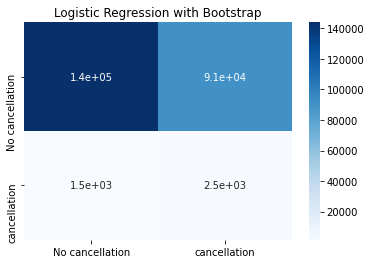

In [33]:
cm=skm.confusion_matrix(y_testdata, y_pred_lr_bs)
sns.heatmap(cm, annot=True,
                    cmap=plt.cm.Blues,
                   xticklabels=['No cancellation', 'cancellation'],
                   yticklabels=['No cancellation', 'cancellation']).set_title('Logistic Regression with Bootstrap')

Text(0.5, 1.0, 'Logistic Regression with smote')

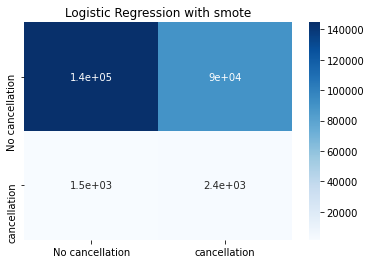

In [34]:
cm=skm.confusion_matrix(y_test, y_pred_lr_sm)
sns.heatmap(cm, annot=True,
                    cmap=plt.cm.Blues,
                   xticklabels=['No cancellation', 'cancellation'],
                   yticklabels=['No cancellation', 'cancellation']).set_title('Logistic Regression with smote')

Text(0.5, 1.0, 'Random Forest with Bootstrap')

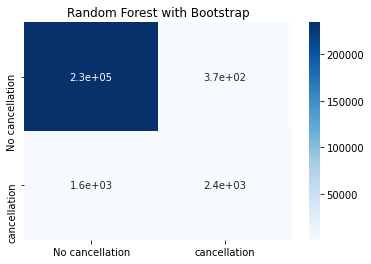

In [35]:
cm=skm.confusion_matrix(y_testdata, y_pred_rf_bs)
sns.heatmap(cm, annot=True,
                    cmap=plt.cm.Blues,
                   xticklabels=['No cancellation', 'cancellation'],
                   yticklabels=['No cancellation', 'cancellation']).set_title('Random Forest with Bootstrap')

Text(0.5, 1.0, 'Random Forest with smote')

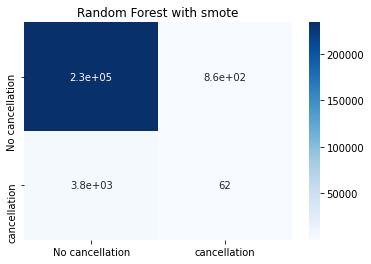

In [36]:
cm=skm.confusion_matrix(y_test, y_pred_rf_sm)
sns.heatmap(cm, annot=True,
                    cmap=plt.cm.Blues,
                   xticklabels=['No cancellation', 'cancellation'],
                   yticklabels=['No cancellation', 'cancellation']).set_title('Random Forest with smote')